In [175]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pprint
from typing import Dict, Sequence

import numpy
import pandas
import seaborn
import torch
from imageio import imread
from ruamel.yaml import YAML
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import imageio

import skimage.segmentation
import scipy.ndimage
import scipy.stats

from hylfm.eval.metrics import compute_metrics_individually, init_metrics
yaml = YAML(typ="safe")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [346]:
# data_name = "11_2__2020-03-11_08.12.13__SinglePlane_-310/20-11-13_23-20-56"  # no lr?
data_name = "11_2__2020-03-11_07.30.39__SinglePlane_-320/20-11-13_23-01-39"
data_name = "11_2__2020-03-11_07.30.39__SinglePlane_-310/20-11-13_23-03-42"

root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/brain/refine_on_slice") / data_name
assert root.exists()
subfolder = "test_dynamic_01/run000/ds0-0"
assert (root / subfolder).exists()
spim_path = root / subfolder / "ls_slice"
pred_path = root / subfolder / "pred"
assert spim_path.exists()
assert pred_path.exists()

In [ ]:
lfd_root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/brain/lr/all/brain." + data_name.split("/")[0])
assert lfd_root.exists()
lfd_subfolder = "run000/ds0-0"
assert (lfd_root / lfd_subfolder).exists()
spim_from_lfd_path = lfd_root / lfd_subfolder / "ls_slice"
lfd_path = lfd_root / lfd_subfolder / "lr_slice"
assert spim_from_lfd_path.exists()
assert lfd_path.exists()

In [348]:
def read_seq_as_stack(path_seq):
    return numpy.stack(imageio.imread(p) for p in sorted(path_seq))

spim = read_seq_as_stack(spim_path.glob("*.tif"))
pred = read_seq_as_stack(pred_path.glob("*.tif"))
assert spim.shape == pred.shape, (spim.shape, pred.shape)
spim.shape, pred.shape

/home/beuttenm/miniconda3/envs/hylfm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


((500, 264, 316), (500, 264, 316))

In [20]:
spim_from_lfd = read_seq_as_stack(spim_from_lfd_path.glob("*.tif"))
lfd = read_seq_as_stack(lfd_path.glob("*.tif"))

assert spim_from_lfd.shape == lfd.shape, (spim_from_lfd.shape, lfd.shape)
assert spim.shape == spim_from_lfd.shape, (spim.shape, spim_from_lfd.shape)
assert numpy.allclose(spim, spim_from_lfd)
spim_from_lfd.shape, lfd.shape

((500, 264, 316), (500, 264, 316))

In [96]:
default_titles = ("spim", "pred", "lfd")
def show(imgs, common_title = "", titles=default_titles):
    fig, axes = plt.subplots(1, len(imgs), figsize=(3 * len(imgs), 3), squeeze=False)
    axes = axes[0]
    for ax, img, title in zip(axes, imgs, titles):
        ax.imshow(img)
        ax.set_title(title)
    
    fig.suptitle(common_title)
    fig.tight_layout()

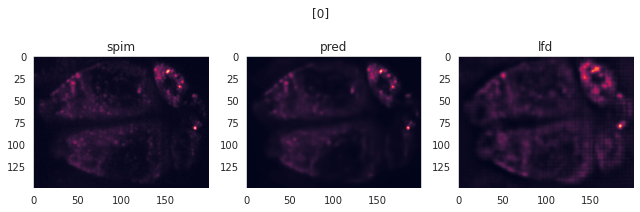

In [326]:
roi = (slice(0, 500), slice(53, 203), slice(80, 280))
# roi = (slice(0, 225), slice(53, 203), slice(80, 280))
# roi = (slice(240, 415), slice(53, 203), slice(80, 280))
selected_spim = spim[roi]
selected_pred = pred[roi]
selected_lfd = lfd[roi]
selected = [selected_spim, selected_pred, selected_lfd]
idx = 0
show([s[idx] for s in selected], f"[{idx}]")

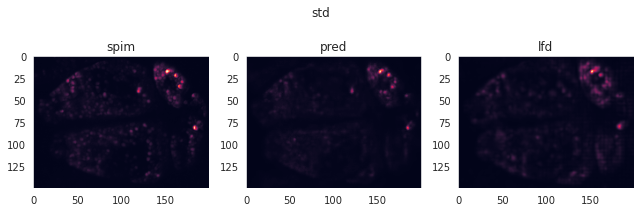

In [327]:
stds = [s.std(axis=0) for s in selected]
show(stds, "std")

In [328]:
def get_running_avg(time_series, r: int):
    return numpy.convolve(time_series, numpy.ones((r,)) / r, mode="valid")

def get_running_avg_of_video(img, r: int):
    assert len(img.shape) == 3
    smooth = numpy.asarray([get_running_avg(ts, r=r) for ts in img.reshape(img.shape[0], -1).T]).T
    return smooth.reshape((img.shape[0] - (r//2)*2, img.shape[1], img.shape[2]))

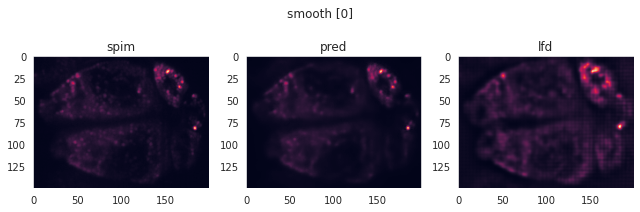

In [329]:
smooth_selected = [get_running_avg_of_video(s, 5) for s in selected]
show([s[idx] for s in smooth_selected], f"smooth [{idx}]")

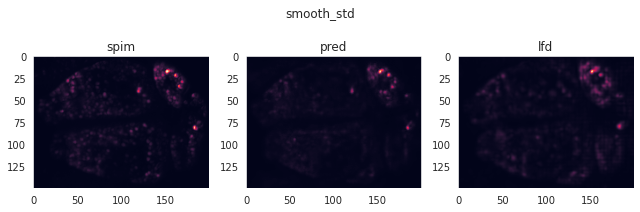

In [330]:
smooth_stds = [s.std(axis=0) for s in smooth_selected]
show(smooth_stds, "smooth_std")

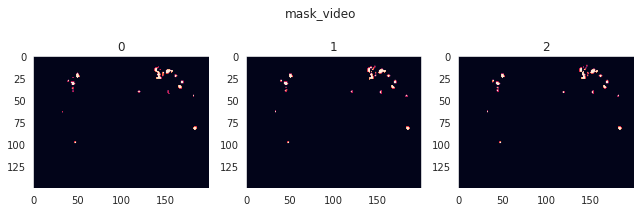

In [331]:
mask_video = selected_spim > .5
show(mask_video[:3], "mask_video", [0, 1, 2])

(150, 200)


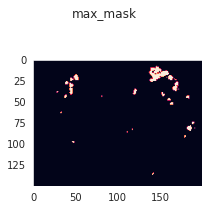

In [332]:
max_mask = mask_video.max(axis=0)
print(max_mask.shape)
show(max_mask[None], "max_mask", [""])

498


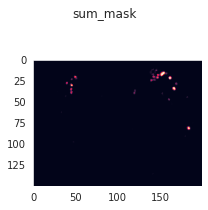

In [333]:
# max_mask = mask_video.max(axis=0)
sum_mask = mask_video.sum(axis=0)
print(sum_mask.max())
show(sum_mask[None], "sum_mask", [""])

In [334]:
# cut_off = numpy.percentile(sum_mask[sum_mask > 0], .99)
# print(cut_off)
# plt.hist(sum_mask[sum_mask > cut_off])

In [335]:
# plt.hist(sum_mask[sum_mask > 5], log=True)

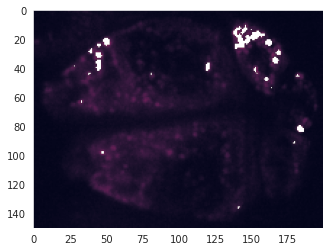

In [336]:
def show_img_with_mask(img, mask):
    mask = mask.astype(numpy.float) - mask.min()
    mask /= mask.max() / 255
    mask = mask.astype(numpy.uint8)
    mask = numpy.stack([mask] * 4, axis=-1)
#     mask[:, :, 3] = mask[:, :, 3]   
    plt.imshow(img)
    plt.imshow(mask)

mask = sum_mask > 5
show_img_with_mask(selected_spim[0], mask)

(150, 200) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


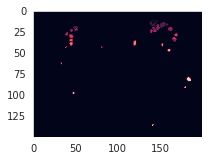

In [337]:
neuron_ids = skimage.segmentation.watershed(-stds[0], mask=mask, watershed_line=True)
print(neuron_ids.shape, numpy.unique(neuron_ids))
show(neuron_ids[None], "", [""])

(150, 200) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


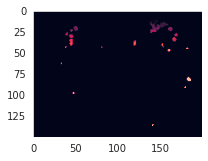

In [338]:
neuron_ids = skimage.segmentation.watershed(-selected_spim.mean(0), mask=mask)
print(neuron_ids.shape, numpy.unique(neuron_ids))
show(neuron_ids[None], "", [""])

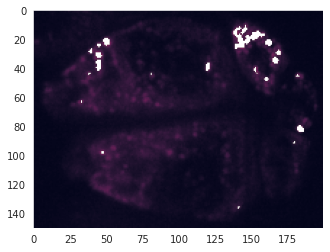

In [339]:
show_img_with_mask(selected_spim[0], neuron_ids > 0)

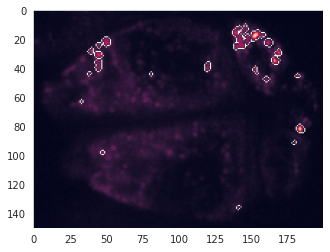

In [340]:
neuron_markers = scipy.ndimage.binary_dilation(neuron_ids) - neuron_ids > 0
show_img_with_mask(selected_spim[0], neuron_markers)

In [341]:
def get_traces(video, neuron_ids):
    traces = []
    for nid in tqdm(range(1, neuron_ids.max() + 1)):
        trace = video[:, neuron_ids == nid]
        traces.append(trace.mean(1))

    return traces

spim_traces = get_traces(selected_spim, neuron_ids)
pred_traces = get_traces(selected_pred, neuron_ids)
lfd_traces = get_traces(selected_lfd, neuron_ids)

print(len(pred_traces))
print(pred_traces[0].shape)

100%|██████████| 36/36 [00:00<00:00, 6327.31it/s]

36
(500,)


In [342]:
pred_prs = numpy.asarray([scipy.stats.pearsonr(st, pt)[0] for st, pt in zip(spim_traces, pred_traces)]) 
lfd_prs = numpy.asarray([scipy.stats.pearsonr(st, lt)[0] for st, lt in zip(spim_traces, lfd_traces)])

Text(0.5, 1.0, 'pearson correlation')

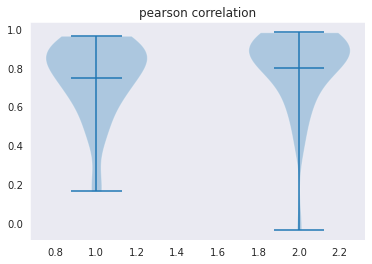

In [343]:
fig, ax = plt.subplots()
# ax.violinplot([pred_prs, lfd_prs], showmeans=False, showmedians=False, quantiles=[[.25, .50, .75]]* 2)
ax.violinplot([pred_prs, lfd_prs], showmeans=True, showmedians=False)
ax.set_title("pearson correlation")

In [344]:
def get_df(neuron_id, pearsonr, name):
#     T = len(pearsonr)
    data = {"neuron_id": [neuron_id] , "pearsonr": [pearsonr], "name": [name]}
#     print(data)
    return pandas.DataFrame.from_dict(data)
    
df = pandas.concat([get_df(nid, pred_prs[nid], "pred") for nid in range(neuron_ids.max())])
df = pandas.concat([df] + [get_df(nid, lfd_prs[nid], "lfd") for nid in range(neuron_ids.max())])
df

,neuron_id,pearsonr,name
0,0,0.900499,pred
0,1,0.758657,pred
0,2,0.709868,pred
0,3,0.964306,pred
0,4,0.609567,pred
...,...,...,...
0,31,0.849708,lfd
0,32,0.858078,lfd
0,33,0.570513,lfd
0,34,0.581913,lfd


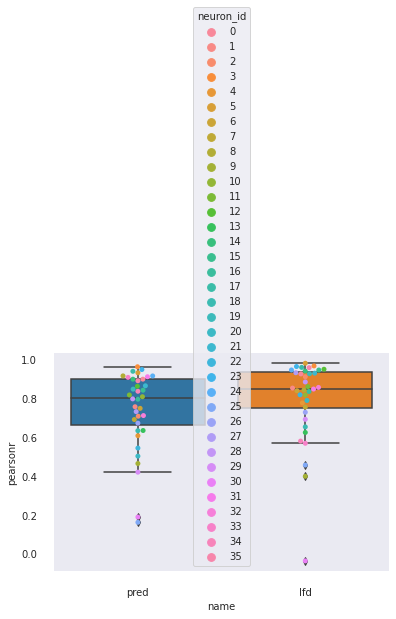

In [345]:
seaborn.set_style("dark")
seaborn.boxplot(x="name", y="pearsonr",
#             hue="neuron_id", palette=["m", "g"],
            data=df)
ax = seaborn.swarmplot(data=df, x="name", y="pearsonr", hue="neuron_id")
seaborn.despine(offset=10, trim=True)


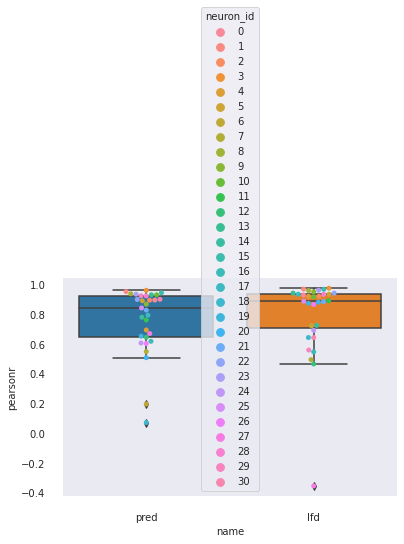

In [259]:
seaborn.set_style("dark")
seaborn.boxplot(x="name", y="pearsonr",
#             hue="neuron_id", palette=["m", "g"],
            data=df)
ax = seaborn.swarmplot(data=df, x="name", y="pearsonr", hue="neuron_id")
seaborn.despine(offset=10, trim=True)


In [325]:
print(pred_prs.mean(), lfd_prs.mean())

0.7628301690045238 0.7942224482084645


In [ ]:
# spim_traces_normalized = 

In [349]:
# def plot_trace(idx):
#     plt.plot(spim_traces[idx], label="spim")
#     plt.plot(pred_traces[idx], label="pred")
#     plt.plot(lfd_traces[idx], label="lfd")
#     plt.legend()
#     plt.show()
    
# for i in range(30):
#     plot_trace(i)